## MNIST CNN

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

### Data

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
path.ls()

[PosixPath('/home/paresh/.fastai/data/mnist_png/training'),
 PosixPath('/home/paresh/.fastai/data/mnist_png/models'),
 PosixPath('/home/paresh/.fastai/data/mnist_png/testing')]

In [5]:
il = ImageList.from_folder(path, convert_mode='L')

In [6]:
il.items[0]

PosixPath('/home/paresh/.fastai/data/mnist_png/training/3/36449.png')

In [7]:
defaults.cmap='binary'

In [8]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/paresh/.fastai/data/mnist_png

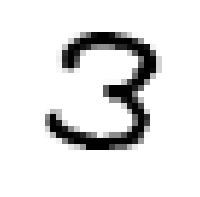

In [9]:
il[0].show()

In [10]:
sd = il.split_by_folder(train='training', valid='testing')

In [11]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/paresh/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/paresh/.fastai/data/mnist_png;

Test: None

In [12]:
(path/'training').ls()

[PosixPath('/home/paresh/.fastai/data/mnist_png/training/3'),
 PosixPath('/home/paresh/.fastai/data/mnist_png/training/5'),
 PosixPath('/home/paresh/.fastai/data/mnist_png/training/0'),
 PosixPath('/home/paresh/.fastai/data/mnist_png/training/4'),
 PosixPath('/home/paresh/.fastai/data/mnist_png/training/6'),
 PosixPath('/home/paresh/.fastai/data/mnist_png/training/1'),
 PosixPath('/home/paresh/.fastai/data/mnist_png/training/2'),
 PosixPath('/home/paresh/.fastai/data/mnist_png/training/7'),
 PosixPath('/home/paresh/.fastai/data/mnist_png/training/9'),
 PosixPath('/home/paresh/.fastai/data/mnist_png/training/8')]

In [13]:
ll = sd.label_from_folder()

In [14]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
3,3,3,3,3
Path: /home/paresh/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
3,3,3,3,3
Path: /home/paresh/.fastai/data/mnist_png;

Test: None

In [15]:
x,y = ll.train[0]

3 torch.Size([1, 28, 28])


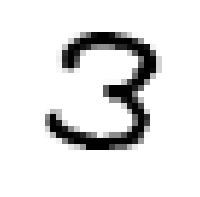

In [16]:
x.show()
print(y,x.shape)

In [17]:
# [*rand_pad(padding=3, size=28, mode='zeros')]

In [18]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [19]:
ll = ll.transform(tfms)

In [20]:
bs = 128

In [21]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [22]:
x,y = data.train_ds[0]

3


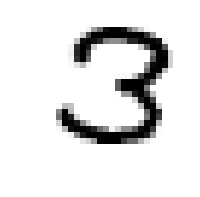

In [23]:
x.show()
print(y)

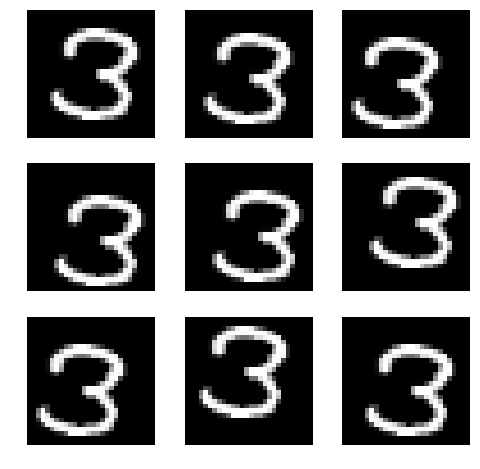

In [24]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [25]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

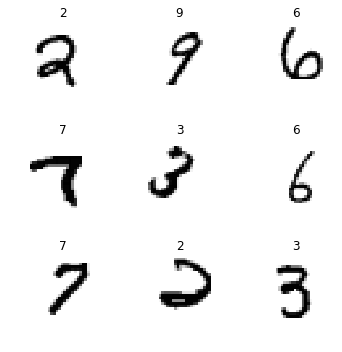

In [26]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [27]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [28]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [29]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [30]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
______________________________________________________________

In [31]:
xb = xb.cuda()

In [32]:
model(xb).shape

torch.Size([128, 10])

In [33]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


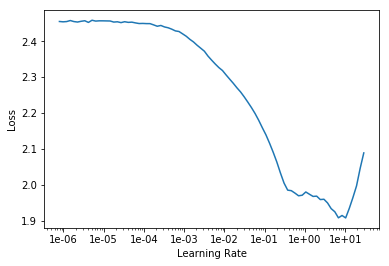

In [34]:
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.214918,0.185344,0.940800,03:50
1,0.126208,0.116383,0.962900,00:07
2,0.068697,0.041460,0.987000,00:07


### Refactor

In [36]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [37]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [38]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [39]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.247853,0.208180,0.932100,00:07
1,0.181316,0.426960,0.881100,00:07
2,0.164913,0.103199,0.968400,00:07
3,0.136499,0.093403,0.970100,00:07
4,0.120847,0.199893,0.930900,00:07
5,0.097926,0.058610,0.982300,00:08
6,0.074343,0.066166,0.980200,00:07
7,0.062312,0.040290,0.987100,00:08
8,0.052229,0.030420,0.990200,00:08
9,0.041411,0.029124,0.990400,00:08


### Resnet-ish

In [40]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [41]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [42]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [43]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [44]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [45]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


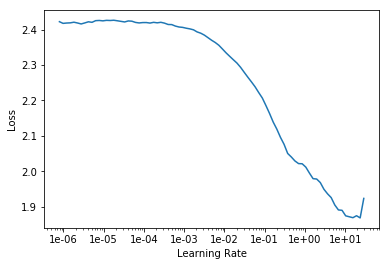

In [46]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.227209,0.362608,0.891700,00:09
1,0.122120,0.151798,0.952300,00:09
2,0.108317,0.280973,0.913100,00:09
3,0.083225,0.204243,0.936800,00:09
4,0.067919,0.071955,0.979600,00:12
5,0.059097,0.085136,0.975100,00:10
6,0.054074,0.039893,0.987500,00:09
7,0.042170,0.041573,0.986900,00:10
8,0.038642,0.023894,0.992300,00:09
9,0.025589,0.018442,0.993900,00:11


In [48]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________

## fin